In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jide/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
# Import Dataset
df = pd.read_json("covid paper 2/staycation.json", lines=True)

In [7]:
df.tail()

,created_at,screen_name,text
1048,2020-05-09 17:22:45+00:00,TeamDarius,DAMN THEIR FALLING LIKE DOMINO'S! I NEED A RES...
1049,2020-05-09 18:55:27+00:00,BartiSkip,Who in their right mind would travel to the UK...
1050,2020-05-09 19:25:00+00:00,WFXRnews,What to do when a family vacation turns into a...
1051,2020-05-09 21:56:40+00:00,cheynw99,you're all right. staycation for me and macy!!...
1052,2020-05-10 00:54:08+00:00,anrod01,"Hello, Can you hear me? I’m over this STAYCAT..."


In [8]:
# Convert to list
data = df.text.values.tolist()

# Remove URL links
data = [re.sub('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove &amp
data = [re.sub("amp", "", sent) for sent in data]

pprint(data[:1])

['staycation for new years thanks to coronavirus ']


In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['staycation', 'for', 'new', 'years', 'thanks', 'to', 'coronavirus']]


In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['amid', 'the', 'outbreak', 'of', 'the', 'coronavirus', 'people', 'in', 'china', 'are', 'finding', 'creative', 'ways', 'to', 'spend', 'their', 'mandatory', 'staycations']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['staycation', 'new', 'year', 'thank']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [14]:
id2word[18]

'regrettably'

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('new', 1), ('staycation', 1), ('thank', 1), ('year', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.242*"staycation" + 0.111*"covid" + 0.036*"home" + 0.026*"go" + '
  '0.023*"stay" + 0.018*"year" + 0.015*"take" + 0.013*"family" + 0.013*"today" '
  '+ 0.011*"safe"'),
 (1,
  '0.055*"stayhome" + 0.037*"live" + 0.029*"kid" + 0.022*"turn" + 0.015*"walk" '
  '+ 0.013*"community" + 0.013*"hard" + 0.013*"non" + 0.011*"fight" + '
  '0.011*"recent"'),
 (2,
  '0.028*"coronavirus" + 0.021*"read" + 0.021*"never" + 0.019*"change" + '
  '0.019*"top" + 0.019*"due" + 0.018*"travel" + 0.018*"look" + 0.018*"world" + '
  '0.017*"nude"'),
 (3,
  '0.047*"need" + 0.037*"tourism" + 0.021*"think" + 0.016*"love" + '
  '0.015*"challenge" + 0.015*"start" + 0.015*"hit" + 0.013*"create" + '
  '0.013*"set" + 0.013*"break"'),
 (4,
  '0.044*"new" + 0.022*"well" + 0.021*"travel" + 0.019*"thank" + '
  '0.018*"easter" + 0.018*"place" + 0.017*"spend" + 0.016*"weekend" + '
  '0.015*"future" + 0.014*"plan"'),
 (5,
  '0.042*"pay" + 0.026*"instead" + 0.023*"selfisolation" + 0.020*"soon" + '
  '0.018*"eat" + 0.017*

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.638539810000827

Coherence Score:  0.4852269644502673


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

AttributeError: 'DataFrame' object has no attribute 'ix'

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [('week', 0.16972477064220184),
   ('hotel', 0.08944954128440367),
   ('quarantine', 0.05045871559633028),
   ('airline', 0.02981651376146789),
   ('big', 0.02981651376146789),
   ('positive', 0.02522935779816514),
   ('return', 0.020642201834862386),
   ('hard', 0.016055045871559634),
   ('job', 0.016055045871559634),
   ('ruin', 0.016055045871559634)]),
 (6,
  [('staycation', 0.1894093686354379),
   ('lockdown', 0.04480651731160896),
   ('lot', 0.04073319755600815),
   ('government', 0.03665987780040733),
   ('spend', 0.034623217922606926),
   ('bad', 0.024439918533604887),
   ('care', 0.02240325865580448),
   ('spring_break', 0.014256619144602852),
   ('advice', 0.014256619144602852),
   ('international', 0.014256619144602852)]),
 (11,
  [('staycation', 0.2832980972515856),
   ('pm_cautiously', 0.05496828752642706),
   ('optimistic', 0.05496828752642706),
   ('industry', 0.042283298097251586),
   ('crisis', 0.03805496828752643),
   ('selfisolation', 0.03171247357293869),
   

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

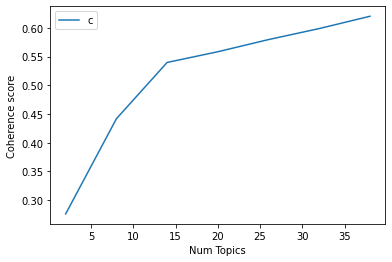

In [24]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2758
Num Topics = 8  has Coherence Value of 0.4416
Num Topics = 14  has Coherence Value of 0.5398
Num Topics = 20  has Coherence Value of 0.5585
Num Topics = 26  has Coherence Value of 0.5796
Num Topics = 32  has Coherence Value of 0.5988
Num Topics = 38  has Coherence Value of 0.6203


In [26]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(15,
  '0.128*"trip" + 0.090*"people" + 0.060*"start" + 0.034*"walk" + 0.034*"road" '
  '+ 0.034*"stop" + 0.030*"vacation" + 0.030*"country" + 0.026*"open" + '
  '0.026*"daily"'),
 (34,
  '0.187*"pandemic" + 0.078*"hit" + 0.057*"vacation" + 0.052*"video" + '
  '0.030*"early" + 0.030*"class" + 0.030*"hard" + 0.022*"town" + '
  '0.022*"beneficiary" + 0.017*"recent"'),
 (30,
  '0.327*"staycation" + 0.039*"buy" + 0.039*"flattenthecurve" + '
  '0.031*"stayhome" + 0.027*"beautiful" + 0.027*"long" + 0.023*"relax" + '
  '0.019*"predict" + 0.019*"springbreak" + 0.016*"project"'),
 (22,
  '0.303*"staycation" + 0.053*"avoid" + 0.048*"end" + 0.038*"save" + '
  '0.034*"spread" + 0.019*"reopen" + 0.014*"service" + 0.014*"prevent" + '
  '0.014*"planning" + 0.010*"line"'),
 (20,
  '0.269*"covid" + 0.115*"free" + 0.047*"create" + 0.036*"story" + '
  '0.024*"crafter_colore" + 0.024*"call" + 0.020*"tour" + 0.020*"finish" + '
  '0.016*"pinter" + 0.016*"pinwheel"'),
 (18,
  '0.142*"covid" + 0.042*"die" + 

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(8)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,26.0,0.0403,"year, safe, back, positive, stay, side, amazin...",staycation for new years thanks to coronavirus
1,1,23.0,0.0482,"covid, place, spend, mind, worry, rest, awesom...","Amid the outbreak of the coronavirus, people i..."
2,2,11.0,0.0647,"staycation, list, big, stayathome, find, super...",🏡Jane-Jane... Regrettably Our Super-Busy and S...
3,3,9.0,0.0522,"travel, change, global, nation, sale, hotel, s...",“Travels in my flat”: Scenes from China’s mand...
4,4,9.0,0.0482,"travel, change, global, nation, sale, hotel, s...",“Travels in my flat”: Scenes from China’s mand...
5,5,23.0,0.0461,"covid, place, spend, mind, worry, rest, awesom...",“Travels in my flat”: Scenes from China’s mand...
6,6,25.0,0.1012,"day, today, call, word, bit, virus, garden, ca...",So Australians in Wuhan get a staycation on CI...
7,7,15.0,0.0401,"trip, people, start, walk, road, stop, vacatio...","As the #coronavirus grips #Wuhan, people on ob..."


In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1072,"make, play, money, world, set, job, traveller,...",How is the new play area looking? Move some st...
1,1.0,0.0989,"vacation, love, cancel, bad, hand, normal, ind...",Canceled Aruba for June...took on Hawaii for F...
2,2.0,0.1357,"coronavirus, top, challenge, nude, zoom, fly, ...",Nude Staycations Zoom To The Top Of The Corona...
3,3.0,0.2029,"night, online, podcast, horizon, head, virtual...",#RT @FLOTUS: RT @CDCgov: Spring break coming u...
4,4.0,0.0738,"staycation, stayathome, write, thought, rememb...",Where are you going? #stayathome #covid_19 #st...


In [30]:
print(sent_topics_sorteddf_mallet)

    Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.1072   
1         1.0              0.0989   
2         2.0              0.1357   
3         3.0              0.2029   
4         4.0              0.0738   
5         5.0              0.1793   
6         6.0              0.0677   
7         7.0              0.1124   
8         8.0              0.1249   
9         9.0              0.1154   
10       10.0              0.2289   
11       11.0              0.0819   
12       12.0              0.1726   
13       13.0              0.1108   
14       14.0              0.0773   
15       15.0              0.1141   
16       16.0              0.1028   
17       17.0              0.2287   
18       18.0              0.2220   
19       19.0              0.1307   
20       20.0              0.1436   
21       21.0              0.0893   
22       22.0              0.0749   
23       23.0              0.1753   
24       24.0              0.1855   
25       25.0              0.1012   
2

In [31]:
# Convert topic tweets to csv
sent_topics_sorteddf_mallet.to_csv('staycationtopictweets.csv')

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,26.0,"year, safe, back, positive, stay, side, amazin...",48.0,0.0456
1.0,23.0,"covid, place, spend, mind, worry, rest, awesom...",31.0,0.0294
2.0,11.0,"staycation, list, big, stayathome, find, super...",38.0,0.0361
3.0,9.0,"travel, change, global, nation, sale, hotel, s...",31.0,0.0294
4.0,9.0,"travel, change, global, nation, sale, hotel, s...",18.0,0.0171
...,...,...,...,...
1048.0,1.0,"vacation, love, cancel, bad, hand, normal, ind...",NaN,NaN
1049.0,35.0,"staycation, optimistic, pm_cautiously, feel, b...",NaN,NaN
1050.0,14.0,"staycation, family, thing, book, long, part, y...",NaN,NaN
1051.0,27.0,"staycation, enjoy, pay, update, flight, bookin...",NaN,NaN


In [33]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"make, play, money, world, set, job, traveller,...",48,0.0456
1.0,1.0,"vacation, love, cancel, bad, hand, normal, ind...",31,0.0294
2.0,2.0,"coronavirus, top, challenge, nude, zoom, fly, ...",38,0.0361
3.0,3.0,"night, online, podcast, horizon, head, virtual...",31,0.0294
4.0,4.0,"staycation, stayathome, write, thought, rememb...",18,0.0171
5.0,5.0,"covid, lot, government, enjoy, deal, include, ...",24,0.0228
6.0,6.0,"staycation, cruise, travel, care, recommend, c...",22,0.0209
7.0,7.0,"travel, summer, tourism, help_local, impact, a...",45,0.0427
8.0,8.0,"covid, leave, turn, kid, house, nice, love, br...",21,0.0199
9.0,9.0,"travel, change, global, nation, sale, hotel, s...",30,0.0285


In [34]:
# Convert dominant topics to csv
df_dominant_topics.to_csv('staycationdominanttopics.csv')